<img src='../img/joint_school_banner_2.png' alt='joint school banner' align='right' width='100%'></img>

<br>

# Metop-A/B GOME-2 Tropospheric NO<sub>2</sub> longterm time-series

### About

The Global Ozone Monitoring Experiment 2 (GOME-2) is an optical spectrometer used for the long-term monitoring of atmospheric trace gas constituents. The GOME-2 instrument has been in orbit on Metop-A since October 2006 until 2020 and on Metop-B since September 2012. 

This workflow shows how to produce a longterm time-series of tropospheric NO<sub>2</sub> based on Metop-A/B GOME-2 Level 3 data between 2007 and 2017, subsetted by different regions. You will use Metop-A/B GOME-2 Level 3 tropospheric NO<sub>2</sub> data from February 2007 and 2017.

Find more information about instrument in the [GOME-2 NO2 (and other trace gases) Product User guides](https://acsaf.org/docs/pum/Product_User_Manual_NTO_OTO_DR_GDP48_Jun_2017.pdf) and the Level 3 data on the [AC SAF website](https://acsaf.org/datarecords/no2_h2o_tcdr.php).

### Basic Facts

> **Spatial resolution**: `0.25° x 0.25°` <br>
> **Spatial coverage**: `Global` <br>
> **Temporal resolution**:  `Monthly` <br>
> **Temporal coverage**: `since 2007 to 2017` <br>
> **Data format**: `NetCDF`


### How to access the data

The GOME-2 Level 3 tropospheric NO<sub>2</sub> data can be downloaded `via FTP` using this [download URL](ftp://acsaf.eoc.dlr.de). You can use an FTP client such as [FileZilla](https://filezilla-project.org/) to access the files. 

You need to first [register for an account](https://acsaf.org/registration_form.html) with AC SAF and log in using the credentials you will receive in an email after registration.

### Module outline
- [Define a list with dictionaries holding bounding boxes for different regions](#region_list)
- [Load Metop-A/B GOME-2 Level 3 data from February 2007 to November 2017](#level3)
- [Create (longterm) spatial mean of tropospheric NO<sub>2</sub>](#longterm_mean)
- [Visualize (longterm) tropospheric NO<sub>2</sub>](#visualize)
 - [Plot tropospheric NO<sub>2</sub> time-series (2007 to 2017)](#plot_level3_ts)
 - [Plot longterm tropospheric NO<sub>2</sub> climatology](#plot_climatology)

#### Load required libraries

In [1]:
import os
import glob

import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.axes import Axes

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import cartopy.feature as cfeature

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='region_list'></a>Define a list with dictionaries holding bounding boxes for different regions

You can define several regions as a dictionary, e.g. the bounding box information for a `Global average`, `Southern Hemisphere` and `Northern Hemisphere`. The dictionaries are stored in a list.

In [3]:
# Global extent
global_extent={'name': 'global_extent',
            'lonmin':-180.0,
            'lonmax':180.0,
            'latmin':-90.0,
            'latmax':90.0}

# Southern Hemisphere extent
sh_extent={'name': 'sh_extent',
            'lonmin':-180.0,
            'lonmax':180.0,
            'latmin':-90.0,
            'latmax':0}

# Northern Hemisphere extent
nh_extent={'name': 'nh_extent',
            'lonmin':-180.0,
            'lonmax':180.0,
            'latmin':0,
            'latmax':90.0}

region_list=[global_extent,
             sh_extent,
             nh_extent]

## <a id='level3'></a>Load Metop-A/B GOME-2 Level 3 data from February 2007 to November 2017

Global Metop-A/B GOME-2 Level 3 data are available from February 2007 to November 2017. From this longterm time-series, you can create a spatial average of a specific region and visualize the monthly tropospheric NO<sub>2</sub> content over time.

#### Load the Metop-A/B GOME-2 Level 3 data files as `xarray.DataArray` with the function `xarray.open_mfdataset()`

The Metop-A/B GOME-2 Level 3 data are disseminated in `netCDF`. The function `xarray.open_mfdataset()` can be used to load the data for all months at once. Use `time` for the keyword argument `concat_dim`.

In [4]:
gome_l3 = xr.open_mfdataset('../../eodata/training_school/gome2/level3/no2-metop-a-b/*.nc', concat_dim='time', combine='nested',  group='PRODUCT')
gome_l3

<xarray.Dataset>
Dimensions:          (time: 130, latitude: 720, longitude: 1440)
Dimensions without coordinates: time, latitude, longitude
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

Above, you can see that the `xarray.Dataset` has three dimensions (`latitude`, `longitude` and `time`), but the dimensions do not have coordinates. However, the coordinate information is required for plotting.

Thus, as a next step, you can load one single Metop-A/B GOME-2 Level 3 file and retrieve the `latitude` and `longitude` coordinates. You can use this information to assign the coordinates to the `xarray.Dataset` above.

In [5]:
ds = xr.open_dataset('../../eodata/training_school/gome2/level3/no2-metop-a-b/GOME_NO2_Global_201701_METOPB_DLR_v1.nc')
ds, ds.latitude, ds.longitude

(<xarray.Dataset>
 Dimensions:    (latitude: 720, longitude: 1440)
 Coordinates:
   * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
   * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
 Data variables:
     *empty*
 Attributes:
     description:  Level 3 NO2 data
     Conventions:  CF-1.6,
 <xarray.DataArray 'latitude' (latitude: 720)>
 array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875],
       dtype=float32)
 Coordinates:
   * latitude  (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
 Attributes:
     standard_name:  latitude
     long_name:      latitude_Centre, center of the grid box
     units:          degrees_north,
 <xarray.DataArray 'longitude' (longitude: 1440)>
 array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
       dtype=float32)
 Coordinates:
   * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
 Attributes:
     standard_name:  longitude
     

#### Assign coordinates to the dimensions `latitude`, `longitude` and `time`

You can use the function `pandas.date_range` from the pandas library to build a list of monthly time coordinates from February 2007 to November 2017.

In [6]:
# Build list of time coordinates with pandas
time_coords = pd.date_range('2007-02', '2017-11', freq='MS').strftime("%Y-%m").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2007-02-01', '2007-03-01', '2007-04-01', '2007-05-01',
               '2007-06-01', '2007-07-01', '2007-08-01', '2007-09-01',
               '2007-10-01', '2007-11-01',
               ...
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01'],
              dtype='datetime64[ns]', length=130, freq=None)

Use the function `xarray.assign_coords()` to assign `latitude`, `longitude` and `time` coordinates to the `gome_l3` `xarray.Dataset` above.

In [7]:
# Assign values to Dataset dimension
gome_l3_assigned = gome_l3.assign_coords(latitude=ds.latitude, longitude=ds.longitude, time=time_coords)
gome_l3_assigned

<xarray.Dataset>
Dimensions:          (time: 130, latitude: 720, longitude: 1440)
Coordinates:
  * latitude         (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude        (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * time             (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2017-11-01
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

## <a id='longterm_mean'></a> Create (longterm) spatial mean of tropospheric NO<sub>2</sub>

Let us loop through the list of regions and create a dictionary containing the following lists:
- **no2_l3**: the spatial average for each month of tropospheric NO<sub>2</sub> of the specific region, and
- **no2_monthly_avg**: the longterm mean of tropospheric NO<sub>2</sub> of each month
- **no2_yearly_avg**: the annual mean of tropospheric NO<sub>2</sub> of each year

The loop makes use of the function [generate_geographical_subset](../functions.ipynb#geographical_subset), which creates a smaller spatial subset based on the bounding box information of each region.

The spatial average of a `xarray.DataArray` is computed with the function `xarray.DataArray.mean()` and specifying the dimension to apply the spatial average with `dim=['latitude', 'longitude']`.

The longterm average is retrieved by using xarray's `groupby('time.month').mean()` aggregator.

In [8]:
# Retrieve the tropospheric NO2 from the xarray Dataset
no2_l3 = gome_l3_assigned.NO2trop

# Initialise an empty dictionary
gome2_l3_dict = {}

# Loop through each item in region list
for region in region_list:
    print(region)
    # Generate a geographical subset
    tmp = generate_geographical_subset(xarray=no2_l3,
                                       latmin=region['latmin'],
                                       latmax=region['latmax'],
                                       lonmin=region['lonmin'],
                                       lonmax=region['lonmax'])
    # Create the spatial average of the region
    tmp_mean = tmp.mean(dim=['latitude','longitude'])
    # Create the longterm climatology of each month
    tmp_climatology_mean = tmp_mean.groupby('time.month').mean()
    # Fill the dictionary with the two lists
    gome2_l3_dict[region['name']]={'no2_l3':tmp_mean,
                                  'no2_monthly_avg': tmp_climatology_mean}
    # Create the annual average of each year
    tmp_annual_mean = tmp_mean.groupby('time.year').mean()
    # Fill the dictionary with the lists
    gome2_l3_dict[region['name']]={'no2_l3':tmp_mean,
                                   'no2_monthly_avg': tmp_climatology_mean,
                                   'no2_yearly_avg': tmp_annual_mean}


{'name': 'global_extent', 'lonmin': -180.0, 'lonmax': 180.0, 'latmin': -90.0, 'latmax': 90.0}
{'name': 'sh_extent', 'lonmin': -180.0, 'lonmax': 180.0, 'latmin': -90.0, 'latmax': 0}
{'name': 'nh_extent', 'lonmin': -180.0, 'lonmax': 180.0, 'latmin': 0, 'latmax': 90.0}


The resulting dictionary contains the three regions as keys and for each region, you can retrieve the time series and climatology of tropospheric NO<sub>2</sub>.

In [9]:
gome2_l3_dict['nh_extent']['no2_l3']

<xarray.DataArray 'NO2trop' (time: 130)>
dask.array<mean_agg-aggregate, shape=(130,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2017-11-01

## <a id='visualize'></a>Visualize (longterm) tropospheric NO<sub>2</sub> 

### <a id='plot_level3_ts'></a>Plot tropospheric NO<sub>2</sub> time-series (2007 to 2017) for a Global average, Southern Hemisphere and Northern Hemisphere.

Let us visualize the tropospheric NO<sub>2</sub> time-series from 2007 to 2017. You can make use of the `xarray.DataArray.plot.line()` function. As dictionary key, you select for each region the `no2_l3` time-series.

We will multiply the data with a conversion factor that improves the legibility of the legend scale.

In [10]:
conversion_factor = 1e-15

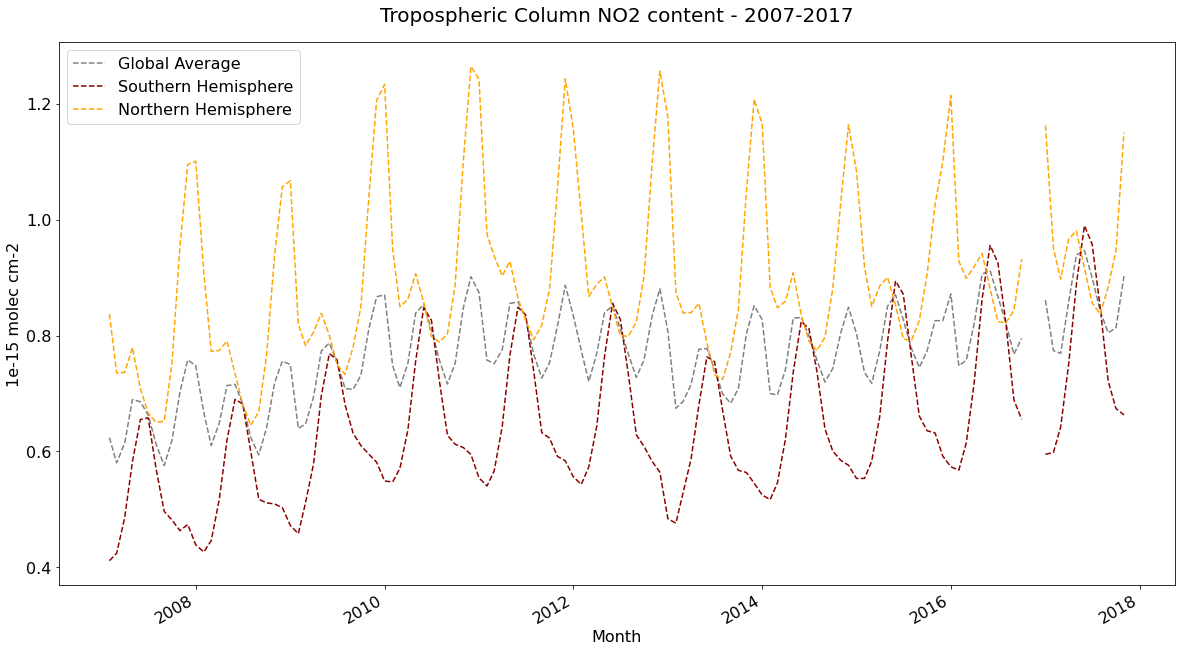

In [11]:
fig = plt.figure(figsize=(20,10))

(gome2_l3_dict['global_extent']['no2_l3']*conversion_factor).plot.line(
    linestyle='dashed',
    color='grey', 
    label='Global Average')

(gome2_l3_dict['sh_extent']['no2_l3']*conversion_factor).plot.line(
    linestyle='dashed',
    color='darkred', 
    label='Southern Hemisphere')

(gome2_l3_dict['nh_extent']['no2_l3']*conversion_factor).plot.line(
    linestyle='dashed',
    color='orange',
    label='Northern Hemisphere')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title(no2_l3.long_name + " - 2007-2017", fontsize=20, pad=20)
plt.ylabel(str(conversion_factor) + ' ' + no2_l3.units, fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.legend(fontsize=16,loc=0)
plt.show()

### <a id='plot_climatology'></a> Plot longterm tropospheric NO<sub>2</sub> climatology for for a Global average, Southern Hemisphere and Northern Hemisphere.

Let us visualize the longterm tropospheric NO<sub>2</sub> climatology for each month (based on the 2007 to 2017 time-series). You can make use of the `xarray.DataArray.plot.line()` function. As dictionary key, you select for each region the `no2_monthly_avg` time-series.

You apply again the conversion factor to make the visualisation of the tropospheric NO<sub>2</sub> more readable. 

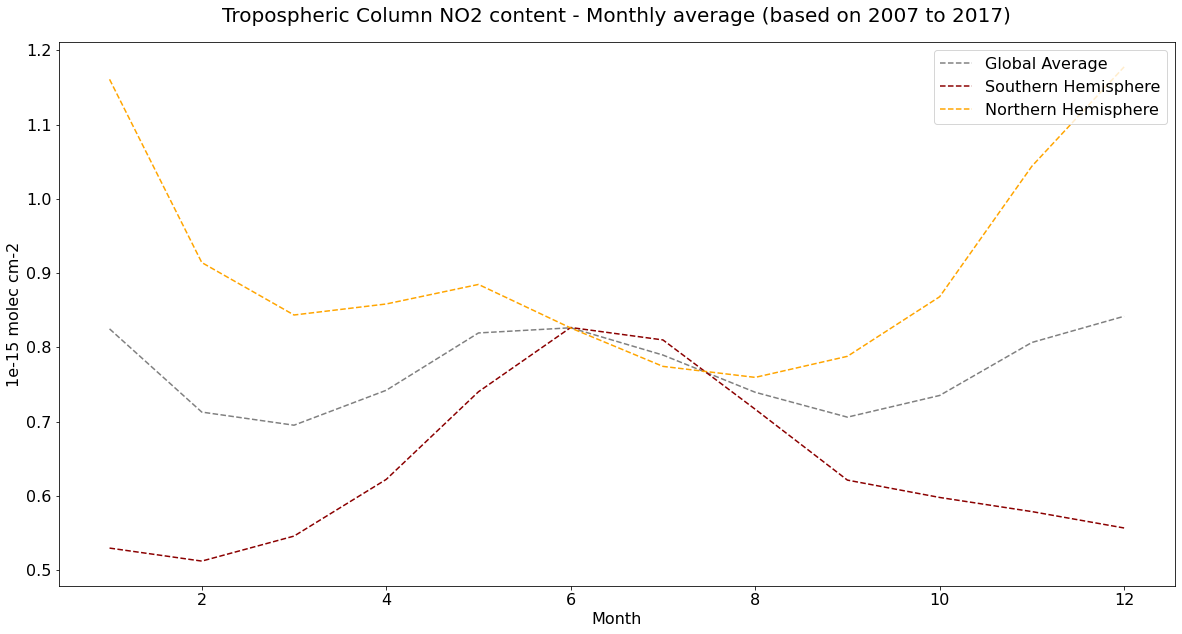

In [12]:
fig = plt.figure(figsize=(20,10))

(gome2_l3_dict['global_extent']['no2_monthly_avg']*conversion_factor).plot.line(
    linestyle='dashed',
    color='grey', 
    label='Global Average')

(gome2_l3_dict['sh_extent']['no2_monthly_avg']*conversion_factor).plot.line(
    linestyle='dashed',
    color='darkred', 
    label='Southern Hemisphere')

(gome2_l3_dict['nh_extent']['no2_monthly_avg']*conversion_factor).plot.line(
    linestyle='dashed',
    color='orange', 
    label='Northern Hemisphere')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title("Tropospheric Column NO2 content - Monthly average (based on 2007 to 2017)", fontsize=20, pad=20)
plt.ylabel(str(conversion_factor) + ' ' + no2_l3.units, fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.legend(fontsize=16,loc=1)
plt.show()

## <a id='visualize_bar_plot'></a>Visualize global average annual time-series of ozone mixing ratio values from 2007 to 2017 as a bar plot

Now you can convert the xarray.DataArray with the annual mean climatology into a Pandas series using `.to_series`. This enables you to plot the data as a bar plot with the function `plot.bar()`.

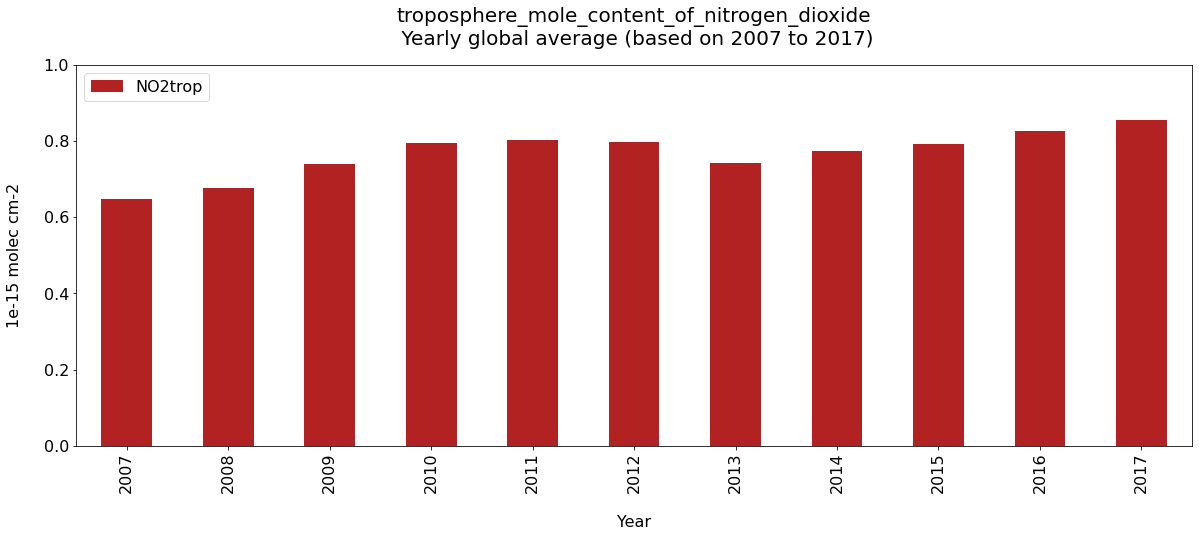

In [13]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20,7))

no2_series = (gome2_l3_dict['global_extent']['no2_yearly_avg']*conversion_factor).to_series()

no2_series.plot.bar( 
    ax=ax, 
    color='firebrick')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_ylim(0,1)

plt.title(no2_l3.standard_name + "\n Yearly global average (based on 2007 to 2017)", fontsize=20, pad=20)
plt.ylabel(str(conversion_factor) + ' ' + no2_l3.units +'\n' , fontsize=16)
plt.xlabel('\nYear', fontsize=16)
plt.legend(fontsize=16,loc=2)
plt.show()

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a>.</p>